In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R

In [4]:
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R

pts = np.load('foo2.npy', allow_pickle=True)

# Remove nan values
pts = pts[np.logical_not(np.isnan(pts['x']))]

# Rotate all points to base_link
for point in pts:
    xyz = np.array([point['x'],point['y'],point['z']])
    r = R.from_euler('xyz', [-0.015, -0.03, -1.45])
    xyz = r.apply(xyz)
    point['x'] = xyz[0]
    point['y'] = xyz[1]
    point['z'] = xyz[2]

# Crop to height, lower rings
pts = pts[
    np.logical_and(
        pts['ring'] <= 6,
        pts['z'] <= 0.5
    )
]

pts = pts[
    np.logical_not(
        np.logical_and(
            np.logical_and(
                pts['y'] >= -2.0,
                pts['y'] <= 2.0
            ),
            np.logical_and(
                pts['x'] >= -2.0,
                pts['x'] <= 2.0
            )
        )
    )
    
]

# Crop by angle
pts = pts[
    np.logical_and(
        np.arctan2(pts['y'],pts['x']) < math.pi/2,
        np.arctan2(pts['y'],pts['x']) > -math.pi/2
    )
]

# for point in pts:
#     xyz = np.array([point['x'],point['y'],point['z']])
#     r = R.from_euler('xyz', [-0.015, -0.03, -1.45])
#     xyz = r.apply(xyz)
#     point['x'] = xyz[0]
#     point['y'] = xyz[1]
#     point['z'] = xyz[2]

angles = np.arctan2(pts['y'],pts['x'])
dist = np.sqrt(
    np.square(pts['x']) +
    np.square(pts['y'])
)

plt.title("X-Y") 
plt.xlabel("Y") 
plt.ylabel("X") 
plt.scatter(-pts['y'], pts['x'], s=10)
plt.show()

plt.title("Distance vs angle") 
plt.xlabel("Angle (rad)") 
plt.ylabel("Height (m)") 
plt.scatter(-1*angles, dist)
plt.show()

plt.title("Distance vs angle") 
plt.xlabel("Angle (rad)") 
plt.ylabel("Height (m)") 
plt.scatter(np.arange(len(dist)), dist)
plt.show()

TypeError: list indices must be integers or slices, not str

(6178,)


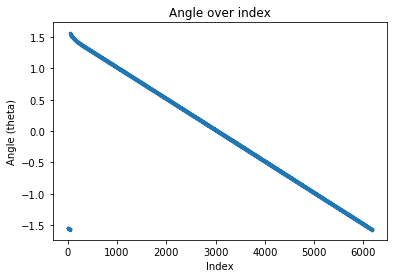

In [ ]:
print(pts.shape)
plt.title("Angle over index") 
plt.xlabel("Index") 
plt.ylabel("Angle (theta)") 
plt.scatter(np.arange(len(pts)), np.arctan2(pts['y'],pts['x']), s=5)
plt.show()

Exiting with dist=0.06309099029239143, angle=0.5488977001204883
Exiting with dist=0.08332608083879975, angle=0.35561349509309353
Exiting with dist=0.06911222895889924, angle=0.24952613007701857
Exiting with dist=0.07253965031319316, angle=0.21027378184667045
Exiting with dist=0.0675440412845795, angle=1.2583194828703084
Exiting with dist=0.06498923061814539, angle=0.1677215593558383
Exiting with dist=0.06351091899995379, angle=0.6566394274550305
Exiting with dist=0.6699674716252049, angle=0.14578537922230744
Exiting with dist=0.064454861954078, angle=0.008957413118394597
Exiting with dist=0.06666834793680176, angle=0.001865234122458502


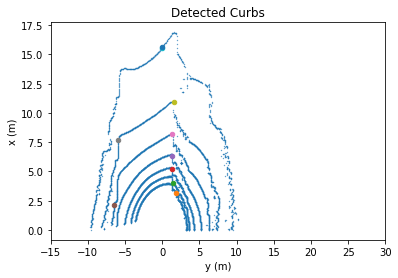

In [ ]:
DIST_TOLERANCE = 0.06 # meters

def dist_2d(ptA, ptB):
    # print("{} AND {}".format(ptA, ptB))
    res =  math.sqrt(
        (ptA['x'] - ptB['x']) ** 2 +
        (ptA['y'] - ptB['y']) ** 2
    )
    return res

def slide(ring_pts):
    # Initial distance is between first two points
    dist: float = dist_2d(ring_pts[0], ring_pts[1])
    min_dist = 1.0
    # Initial state is no curb
    prev_point = ring_pts[0]
    
    for pt in ring_pts[1:]:
        dist = dist_2d(pt, prev_point)
        abs_angle = abs(math.atan2(pt['y'],pt['x']))
        if dist > DIST_TOLERANCE and abs_angle < 1.4:
            print("Exiting with dist={}, angle={}".format(dist, abs_angle))
            return prev_point
        if dist < min_dist:
            dist = min_dist
        # print(dist)
        prev_point = pt
    # print("No curb found. Min dist: {}".format(min_dist))

def slideWindow(ring_pts):
    # Find index of point at theta=0
    angles = np.arctan2(ring_pts['y'],ring_pts['x'])
    abs_angles = np.abs(angles)
    zero_idx = np.argmin(abs_angles)
    # print(ring_pts[zero_idx])

    # ring_pts = ring_pts[angles>0]
    # angles = angles[angles>0]
    left_pts = ring_pts[:zero_idx]
    left_curb_pt = slide(left_pts[::-1])
    # if pt is not None:
    #     plt.scatter(-pt['y'], pt['x'], s=20)

    right_pts = ring_pts[zero_idx:]
    right_curb_pt = slide(right_pts[::1])
    # if pt is not None:
    #     plt.scatter(-pt['y'], pt['x'], s=20)

    # plt.title("Left Pane") 
    # plt.xlabel("y (m)") 
    # plt.ylabel("x (m)") 
    # plt.scatter(-ring_pts['y'], ring_pts['x'], s=5)
    # if pt is not None:
    #     plt.scatter(-pt['y'], pt['x'], s=20)
    # plt.show()

    return (left_curb_pt, right_curb_pt)

curb_bounds = []

for ring in range(7):
    ring_pts = pts[pts['ring']==ring]
    curb_bounds.append(slideWindow(ring_pts))

plt.title("Detected Curbs") 
plt.xlabel("y (m)") 
plt.ylabel("x (m)") 
plt.xlim(-15, 30)
plt.scatter(-pts['y'], pts['x'], s=0.1)



for ring_bound in curb_bounds:
    if ring_bound[0] is not None:
        plt.scatter(-ring_bound[0]['y'], ring_bound[0]['x'], s=20)
    if ring_bound[1] is not None:
        plt.scatter(-ring_bound[1]['y'], ring_bound[1]['x'], s=20)

plt.show()